# Implementing a Key-Value Database

In [235]:
from btree import BTree

In [236]:
class KVStore(BTree):
    def __init__(self):
        super().__init__(2)
        
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node:
            for i, k in enumerate(node.keys):
                if k == key:
                    node.values[i] = value
                    
        else:
            super().add(key, value)

## Testing

- The split threshold of a KVStore equals 2.
- If we add an entry with the `KVStore.add()` method and retrieve it with the `KVStore.get_value()`, we get the same value that was added.
- If we add two entries with the same key and different values, the value updates.

In [237]:
kv = KVStore()

In [238]:
assert kv.split_threshold == 2, "The split should be equal to 2."

In [239]:
kv.add(20, 1)
assert kv.get_value(20) == 1

In [240]:
kv.add(20, 2)
assert kv.get_value(20) == 2

## Implementing the Item Getter and Setter

In [241]:
class KVStore(BTree):
    def __init__(self):
        super().__init__(2)
        
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node:
            for i, k in enumerate(node.keys):
                if k == key:
                    node.values[i] = value
                    
        else:
            super().add(key, value)
        
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __setitem__(self, key, value):
        self.add(key, value)

## Testing Getter and Setter

In [242]:
kv = KVStore()

In [243]:
kv[4] = 40
assert kv[4] == 40, "Got unexpected key value"

In [244]:
print(kv[4])

40


## Enhancing the Contains Method

In [245]:
class KVStore(BTree):
    def __init__(self):
        super().__init__(2)
        
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node:
            for i, k in enumerate(node.keys):
                if k == key:
                    node.values[i] = value             
        else:
            super().add(key, value)
        
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __contains__(self, key):
        return self.contains(key)

## Testing the In Operator

In [246]:
kv = KVStore()

In [247]:
kv[3] = 30
assert 3 in kv, "Inserted key not found"

In [248]:
if 3 in kv:
    print("Found key")

Found key


## Range Queries

In [249]:
class KVStore(BTree):
    def __init__(self):
        super().__init__(2)
        
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node:
            for i, k in enumerate(node.keys):
                if k == key:
                    node.values[i] = value             
        else:
            super().add(key, value)
        
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __contains__(self, key):
        return self.contains(key)
    
    def _range_query(self, range_start, range_end, current_node, min_key, max_key):
        if range_start > max_key or range_end < min_key:
            return []
        results = []
        for i, key in enumerate(current_node.keys):
            if range_start <= key and key <= range_end:
                results.append(current_node.values[i])
        if not current_node.is_leaf():
            for i, child in enumerate(current_node.children):
                new_min_key = current_node.keys[i - 1] if i > 0 else min_key
                new_max_key = current_node.keys[i] if i < len(current_node) else max_key
                results += self._range_query(range_start, range_end, child, new_min_key, new_max_key)
        return results 

    def range_query(self, range_start, range_end):
        return self._range_query(range_start, range_end, self.root, float('-inf'), float('inf'))

In [250]:
kv = KVStore()

In [251]:
kv[1] = 10
kv[2] = 20
kv[3] = 30
kv[4] = 40
kv[5] = 50

In [252]:
print(kv.range_query(2, 4))

[20, 40, 30]


In [253]:
print(kv.range_query(4, 9))

[40, 50]


In [254]:
print(kv.range_query(1, 5))

[20, 40, 10, 30, 50]


## Random Tests

In [255]:
class DictKVStore(dict):

    def range_query(self, range_start, range_end):
        result = []
        for key in self.keys():
            if range_start <= key and key <= range_end:
                result.append(self[key])
        return result

In [256]:
dict_kv = DictKVStore()
our_kv = KVStore()
for i in range(10):
    dict_kv[i] = i
    our_kv[i] = i

for range_start, range_end in [(1, 3), (4, 6), (1, 10), (5, 5)]:
    dict_res = sorted(dict_kv.range_query(range_start, range_end))
    our_res = sorted(our_kv.range_query(range_start, range_end))
    assert dict_res == our_res, "Both data structures did not return the same range query result."

## Performance Testing

In [257]:
import pandas as pd

In [258]:
entries = pd.read_csv("entries.csv")

In [259]:
entries.head()

,key,value
0,9869,2874
1,40914,13091
2,8864,67309
3,3090,24615
4,48220,25813


In [260]:
entries.shape

(50000, 2)

In [261]:
queries = pd.read_csv("queries.csv")

In [262]:
queries.head(10)

,range_start,range_end
0,31244,31244
1,43736,43737
2,47449,47451
3,29828,29831
4,29593,29597
5,18638,18643
6,6716,6722
7,46706,46713
8,11385,11393
9,7539,7548


In [263]:
queries.dtypes

range_start    int64
range_end      int64
dtype: object

In [264]:
queries.shape

(999, 2)

In [265]:
kv_dict = DictKVStore()
kv_btree = KVStore()

In [266]:
for i, row in entries[:5].iterrows():
    key = row["key"]
    value = row["value"]
    kv_dict[key] = value
    kv_btree[key] = value

In [267]:
import time

In [268]:
time_ratios = []

In [269]:
for i, row in queries.iterrows():
    range_start = row["range_start"]
    range_end = row["range_end"]
    
    start = time.time()
    kv_dict.range_query(range_start, range_end)
    end = time.time()
    kv_dict_query_time = end - start
    
    start = time.time()
    kv_btree.range_query(range_start, range_end)
    end = time.time()
    kv_btree_query_time = end - start
    
    time_ratios.append(kv_dict_query_time / kv_btree_query_time)

In [270]:
%matplotlib inline

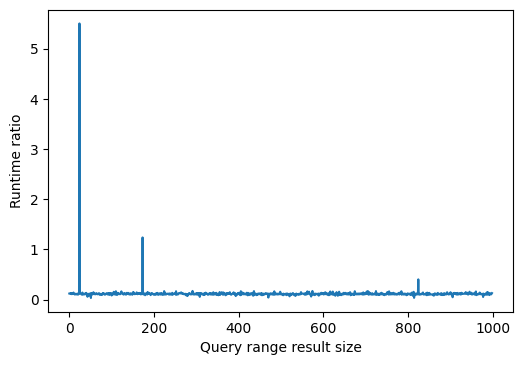

In [271]:
import matplotlib.pyplot as plt
plt.plot(time_ratios)
plt.xlabel('Query range result size')
plt.ylabel('Runtime ratio')
plt.show()